# Deep Learning for Article Classification with Publication using Kaggle Data

Here is the link for data - https://www.kaggle.com/snapcrack/all-the-news (courtesy of Andrew Thompson)

------------
**This is the second part. A brief about the objective and dataset is given below. In the first part, we are done with data cleaning, processing, and its splitting into train and test sets**

**We are building a text classifier with Keras and 1-D Convolutional Neural Networks for the Kaggle dataset containing information such as title, author, publication and the content of the article. This data set includes several publications but we focus on top 5 publications (all US publishers) as labels acting for the title and content as features. Below is the description of labels.**

    Label	Description
    0	    Breitbart
    1	    New York Post
    2	    NPR (National Public Radio)
    3	    Washington Post
    4	    Reuters

## Let's start with encoding of data

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
import pandas as pd

In [3]:
!python3 --version

Python 3.8.7


In [4]:
ls # My data from Part-1 is found in my working directory

 Volume in drive C is OS
 Volume Serial Number is 9A03-93AF

 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN


 Directory of C:\Users\anmol\Deep NN



File Not Found


**Loading data using pickle**

In [5]:
X_train = pd.read_pickle("./X_train.pkl")[0].to_list()

In [6]:
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

**Using Tokenizer from Keras, the tokenizer object first fits onto the training text**

In [7]:
tokenizer = create_tokenizer(X_train)

**The max_length of tokenizer would give the max length of text in the training set**

In [8]:
def max_length(lines):
	return max([len(s.split()) for s in lines])

In [9]:
length = max_length(X_train)

In [10]:
length

12052

**The vocab_size of tokenizer would give the number of unique words in the training set (using word_index attribute of object)**

In [11]:
vocab_size = len(tokenizer.word_index) + 1

In [12]:
vocab_size

157706

**Here, we encode the text to sequences using texts_to_sequences attribute which will give out Text2Seq features representing the sequence with which words appear in the text**

**The pad_sequences funtion pads the sequence (vector of integers) with 0s if its length is less than that of a text that has maximum length. This ensures that the uniformity in size is maintained**

In [13]:
def encode_text(tokenizer, lines, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(lines)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded

In [14]:
len(X_train)

52183

In [15]:
trainX = encode_text(tokenizer, X_train, length) #Encoding training set

In [16]:
import pickle

In [17]:
X_test = pd.read_pickle("./X_test.pkl")[0].to_list()

In [18]:
testX = encode_text(tokenizer, X_test, length) #Encoding test set

**Dumping the encoded train and test sets**

In [19]:
with open("./X_train_encoded.pkl", 'wb') as f:
    pickle.dump(trainX, f, protocol=4)

In [20]:
with open("./X_test_encoded.pkl", 'wb') as f:
    pickle.dump(testX, f, protocol=4)

## Model Building

**Now, we can start with building the model**

In [21]:
## Importing relevant libraries

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate

from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

import pickle
import pandas as pd

**Loading training and test sets (in case a fresh instance is started)**

In [22]:
with open("./X_train_encoded.pkl", 'rb') as f:
    trainX = pickle.load(f)

In [23]:
with open("./X_test_encoded.pkl", 'rb') as f:
    testX = pickle.load(f)

In [24]:
length, vocab_size = 12052, 157706  # Values taken from above deduced variables

In [25]:
y_train_cat = pd.read_pickle("./y_train_cat.pkl").to_numpy()
y_test_cat = pd.read_pickle("./y_test_cat.pkl").to_numpy()

**Configuring Model below**

**Explaining the model-**

The model takes three layers as inputs (matris of encoded vectors of text just repeated thrice). Each layer is evaluated as a separate channel with a different kernel_size that traverses and convolutes with the vectors.

An embedding layer first embeds the encoded vectors to generate another vector of size 10 for each datapoint. This process is same for all three channels.

A 1-dimensional convolutional layer then traverses over the matrix of embedded vectors (meaning the stride happens only in the vertical direction - see figure below denoting red boundary box as kernel). The kernel size differs for the three channels producing features that capture the sequence of words with different length.

A dropout, 1-D pooling and flatten layer is applied to each channel with same hyper-parameters

The flattened features are then concatenated together to produce a single set of features which is then passed on to another dense layers and then finally given out as output containing 5 neurons for each label

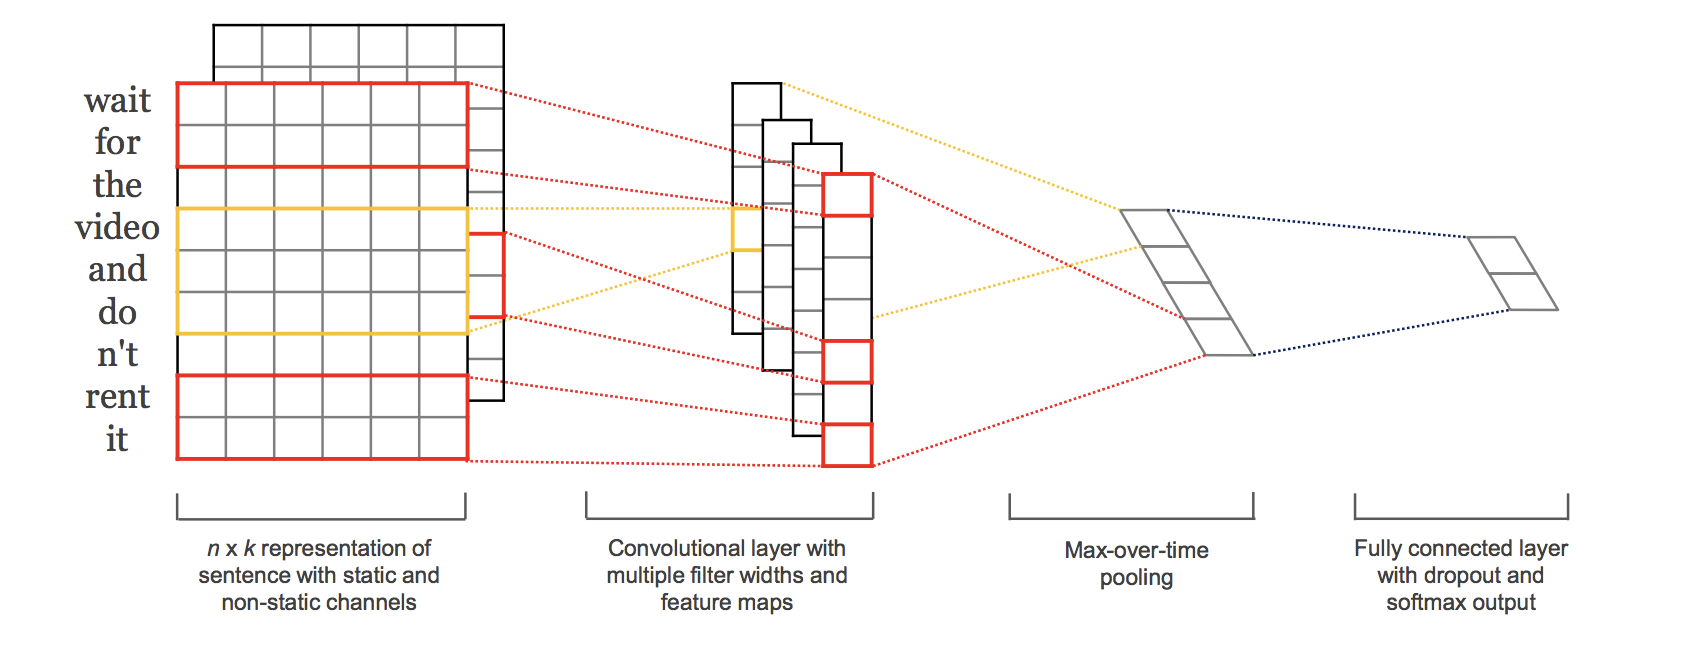

In [26]:
# C-1
inputs1 = Input(shape=length)
embedding1 = Embedding(input_dim=vocab_size, output_dim=10)(inputs1)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
flat1 = Flatten()(pool1)


# C-2
inputs2 = Input(shape=length)
embedding2 = Embedding(input_dim=vocab_size, output_dim=10)(inputs2)
conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=2)(drop2)
flat2 = Flatten()(pool2)


# C-3
inputs3 = Input(shape=length)
embedding3 = Embedding(input_dim=vocab_size, output_dim=10)(inputs3)
conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=2)(drop3)
flat3 = Flatten()(pool3)

merge = concatenate([flat1, flat2, flat3])

dense1 = Dense(64, activation='relu')(merge)

outputs = Dense(5, activation='softmax')(dense1)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Adam optimizer and categorical_crossentropy applied while compiling**

**Below, we see the summary of model denoting number of parameters and shape of features at each layer**

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12052)]      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12052)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 12052)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 12052, 10)    1577060     input_1[0][0]                    
______________________________________________________________________________________________

**An early stop mechanism applied that stops training when val_loss stops reducing**

In [28]:
earlystop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

**Fitting the model with 10 epochs and batch_size of 16**

In [29]:
model.fit([trainX,trainX,trainX], y_train_cat, validation_data=([testX, testX, testX], y_test_cat), 
          epochs=10, batch_size=32, callbacks=[earlystop])

Epoch 1/10
1631/1631 [==============================] - 1863s 1s/step - loss: 1.0791 - accuracy: 0.5756 - val_loss: 0.3896 - val_accuracy: 0.8656
Epoch 2/10
1631/1631 [==============================] - 1844s 1s/step - loss: 0.1909 - accuracy: 0.9358 - val_loss: 0.3644 - val_accuracy: 0.8755
Epoch 3/10
1631/1631 [==============================] - 1883s 1s/step - loss: 0.0580 - accuracy: 0.9829 - val_loss: 0.4789 - val_accuracy: 0.8672
Epoch 4/10
1631/1631 [==============================] - 1830s 1s/step - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.6246 - val_accuracy: 0.8634


## Model Evaluation

In [30]:
loss_acc_hist = pd.DataFrame(model.history.history)
loss_acc_hist

,loss,accuracy,val_loss,val_accuracy
0,0.707933,0.724776,0.389643,0.865594
1,0.196036,0.934327,0.364400,0.875475
2,0.060391,0.981258,0.478939,0.867248
3,0.027978,0.991262,0.624587,0.863358


In [31]:
import matplotlib.pyplot as plt

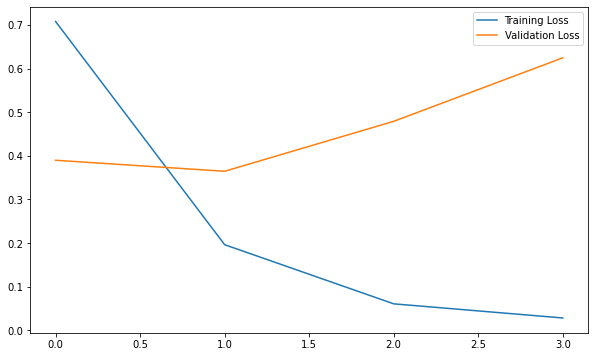

In [32]:
plt.figure(figsize=(10,6))
plt.plot(loss_acc_hist['loss'], label='Training Loss')
plt.plot( loss_acc_hist['val_loss'], label='Validation Loss')
plt.legend()

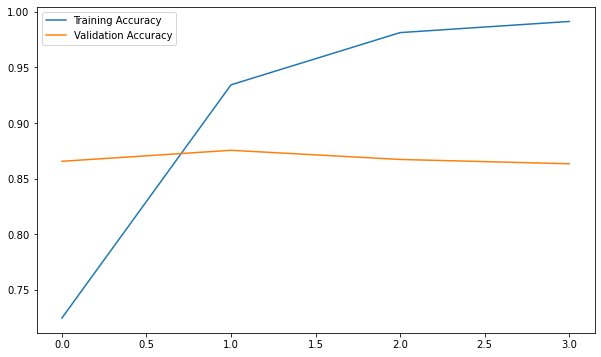

In [33]:
plt.figure(figsize=(10,6))
plt.plot(loss_acc_hist['accuracy'], label='Training Accuracy')
plt.plot( loss_acc_hist['val_accuracy'], label='Validation Accuracy')
plt.legend()

**Saving model and its weights**

In [34]:
model.save('trial1.h5')

In [35]:
model.save_weights('trial1_weights')

In [36]:
from tensorflow.keras.models import load_model
import pandas as pd
import pickle
import numpy as np

In [37]:
model = load_model('trial1.h5')

In [38]:
with open("./X_train_encoded.pkl", 'rb') as f:
    trainX = pickle.load(f)

In [39]:
with open("./X_test_encoded.pkl", 'rb') as f:
    testX = pickle.load(f)

In [40]:
y_train_cat = pd.read_pickle("./y_train_cat.pkl").to_numpy()
y_test_cat = pd.read_pickle("./y_test_cat.pkl").to_numpy()

**Evaluating on Training Set**

In [41]:
loss_train, acc_train = model.evaluate(x=[trainX,trainX,trainX], y=y_train_cat)

1631/1631 [==============================] - 291s 178ms/step - loss: 0.0873 - accuracy: 0.9822


**Evaluating on Testing Set**

In [42]:
loss_test, acc_test = model.evaluate(x=[testX,testX,testX], y=y_test_cat)

699/699 [==============================] - 124s 177ms/step - loss: 0.3644 - accuracy: 0.8755 - loss: 0.365


In [43]:
print("Testing accuracy is:", acc_test*100)

Testing accuracy is: 87.54750490188599


**Computing Model's classification report and confusion Matrix**

In [44]:
predictions = np.argmax(model.predict([testX,testX,testX]), axis=-1)

In [45]:
with open("./predictions.pkl", 'wb') as f:
    pickle.dump(predictions, f, protocol=4)

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

In [47]:
y_test_cat

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [48]:
y_test = np.argmax(y_test_cat, axis=-1)

In [49]:
predictions

array([0, 3, 0, ..., 0, 4, 2], dtype=int64)

In [50]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      7099
           1       0.84      0.76      0.80      3494
           2       0.76      0.92      0.83      5244
           3       0.99      0.98      0.99      3213
           4       0.88      0.76      0.81      3315

    accuracy                           0.88     22365
   macro avg       0.88      0.87      0.87     22365
weighted avg       0.88      0.88      0.88     22365



In [57]:
from collections import Counter

Counter(np.argmax(y_train_cat, axis=1))

Counter({2: 12237, 4: 7733, 3: 7496, 0: 16565, 1: 8152})

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

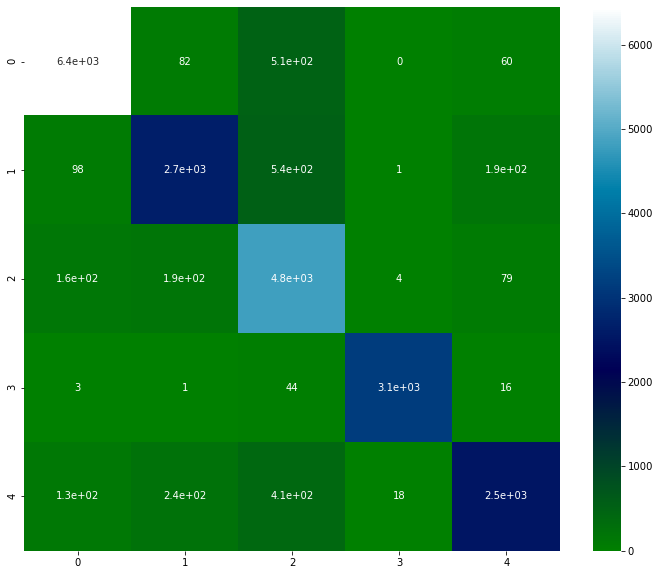

In [52]:
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='ocean')

**The model has performed quite well (with some over-fitting maybe). No hyper-parameter tuning was involved though**

**This concludes the application of Text Classification with 1-dimensional CNN with simultaneous training of inputs (as Embedding layer)**

**The results show that publications (and their authors) write titles and the articles in their own unique way which is quite distinctive from each other. The sequence of words being captured shows this!**